# Setup

In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot
import logging
import tpvalidator.mcprod.workspace as workspace
import tpvalidator.utilities as utils
import tpvalidator.mcprod.analyzers.snn as snn

from rich import print
from tpvalidator.utilities import temporary_log_level, subplot_autogrid, pandas_backend
from tpvalidator.histograms import uproot_hist_mean_std


# Argon 39 dataset

In [3]:
from pathlib import Path
pre_prod_dir = Path('../../data/vd/pre_prod/')
with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.WARN):
    ar39_ws = workspace.TriggerPrimitivesWorkspace(pre_prod_dir / 'anatree_vd_ar39_hist.root')

ar39_ws.add_rawdigits(pre_prod_dir / 'rawdigits' / 'trigger_digits_waves_detsim_vd_ar39.root')

print(ar39_ws.info)

ws=ar39_ws

None

{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 45,
            'threshold_tpg_plane1': 45,
            'threshold_tpg_plane2': 45,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

## SimIDEs properties

In [4]:
ws.ides

,event,run,subrun,channel,timestamp,numelectrons,energy,x,y,z,trackID,origTrackID,readout_plane_id,readout_view,detector_element
0,1,20000047,0,24,824,3.140217,0.000335,-159.647369,-660.258118,17.497156,2688,-999.0,0.0,0.0,0.0
1,1,20000047,0,24,825,11.719005,0.001249,-159.647369,-660.258118,17.497156,2688,-999.0,0.0,0.0,0.0
2,1,20000047,0,24,826,33.323917,0.003550,-159.647369,-660.258118,17.497156,2688,-999.0,0.0,0.0,0.0
3,1,20000047,0,24,827,72.215294,0.007694,-159.647369,-660.258118,17.497156,2688,-999.0,0.0,0.0,0.0
4,1,20000047,0,24,828,119.279793,0.012708,-159.647369,-660.258118,17.497156,2688,-999.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31180437,100,20000047,0,41467,7304,7.258955,0.001230,178.323761,514.390564,893.588318,5596,-999.0,2.0,2.0,47.0
31180438,100,20000047,0,41467,7305,29.874031,0.005063,178.323761,514.390564,893.588318,5596,-999.0,2.0,2.0,47.0
31180439,100,20000047,0,41467,7306,48.289700,0.008184,178.323761,514.390564,893.588318,5596,-999.0,2.0,2.0,47.0
31180440,100,20000047,0,41467,7307,30.775732,0.005216,178.323761,514.390564,893.588318,5596,-999.0,2.0,2.0,47.0


### SimIDEs distributions
Overview amd focus on the start and end of the readout window

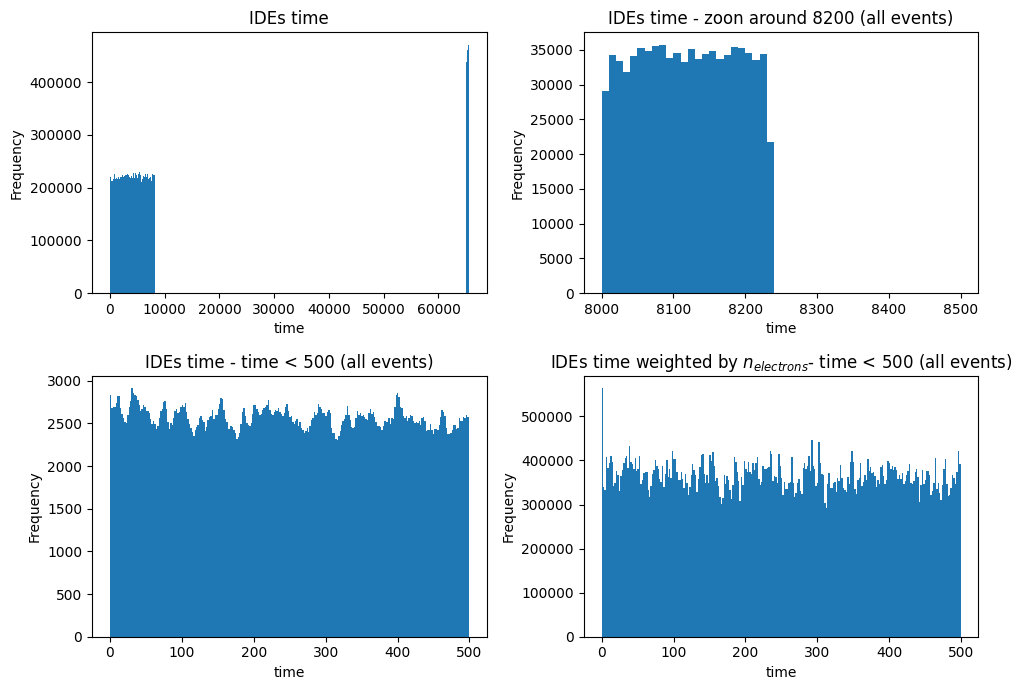

In [92]:
fig, axes = plt.subplots(2,2, squeeze=False, figsize=(10,7))

ax = axes[0,0]
# ws.ides.query('event==1').timestamp.plot.hist(bins=1000, ax=ax)
ws.ides.timestamp.plot.hist(bins=1000, ax=ax)
ax.set_xlabel('time')
ax.set_title('IDEs time')

ax = axes[0,1]
bins=list(range(8000, 8501, 10))
ws.ides.query('timestamp > 8000 & timestamp < 8500').timestamp.plot.hist(bins=bins, ax=ax)
ax.set_xlabel('time')
ax.set_title('IDEs time - zoon around 8200 (all events)')

early_ides = ws.ides.query('timestamp <  500 & readout_view ==2')

ax = axes[1,0]
early_ides.timestamp.plot.hist(bins=250, ax=ax)
ax.set_xlabel('time')
ax.set_title('IDEs time - time < 500 (all events)')

ax = axes[1,1]
early_ides.timestamp.plot.hist(bins=250, weights=early_ides.numelectrons, ax=ax)
ax.set_xlabel('time')
ax.set_title('IDEs time weighted by $n_{electrons}$- time < 500 (all events)')

fig.tight_layout()


### SimIDEs outside readout window (t>> 8500)

In [91]:
ar39_ws.ides.timestamp.max()

np.int32(65535)

498

65037 65535 None

<Axes: >

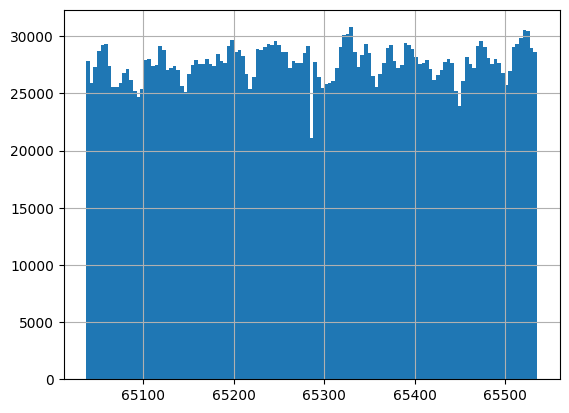

In [5]:
fig, axes = plt.subplots()
odd_ides = ar39_ws.ides.query('timestamp > 60000')
print(odd_ides.timestamp.min(), odd_ides.timestamp.max(), print(odd_ides.timestamp.max()-odd_ides.timestamp.min()))
odd_ides.timestamp.hist(bins=125, ax=axes)

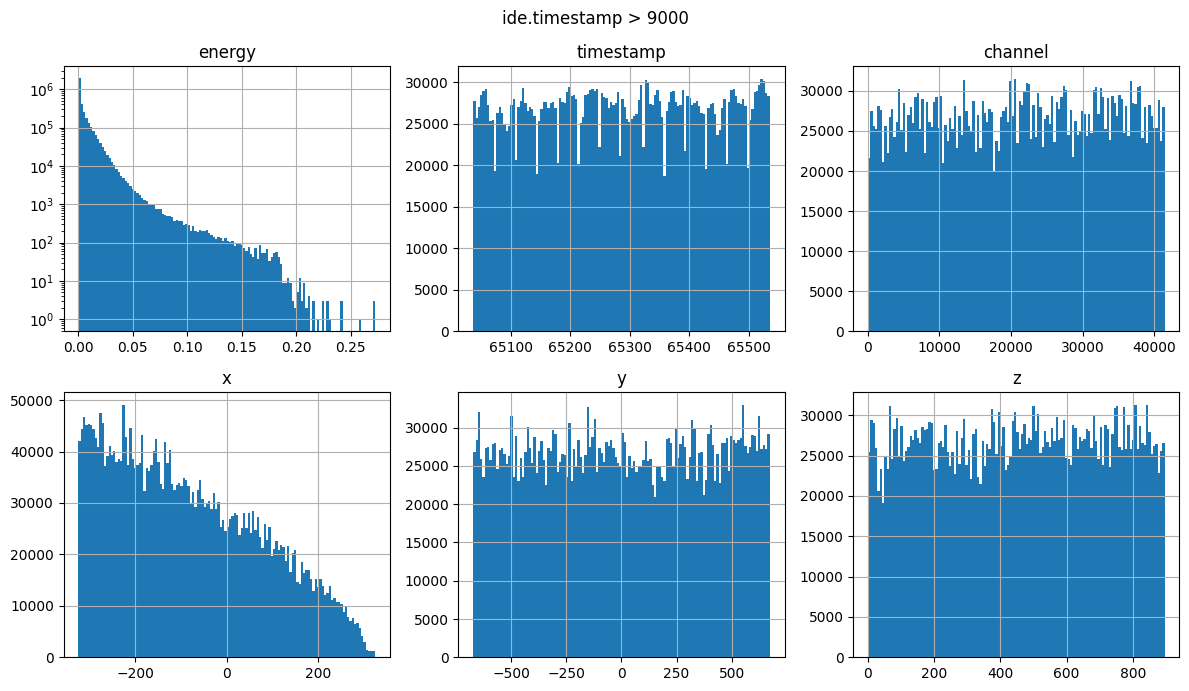

In [120]:
fig,axes = plt.subplots(2,3, figsize=(12,7))

q='timestamp > 9000 & event<100'
b=128
# q='timestamp < 100 & event<100'
# b=100

ax=axes[0][0]
ws.ides.query(q).energy.hist(ax=ax, bins=b)
ax.set_title('energy')
ax.set_yscale('log')

ax=axes[0][1]
ws.ides.query(q).timestamp.hist(ax=ax, bins=b)
ax.set_title('timestamp')

ax=axes[0][2]
ws.ides.query(q).channel.hist(ax=ax, bins=b)
ax.set_title('channel')

ax=axes[1][0]
ws.ides.query(q).x.hist(ax=ax, bins=b)
ax.set_title('x')

ax=axes[1][1]
ws.ides.query(q).y.hist(ax=ax, bins=b)
ax.set_title('y')

ax=axes[1][2]
ws.ides.query(q).z.hist(ax=ax, bins=b)
ax.set_title('z')

fig.suptitle('ide.timestamp > 9000')
fig.tight_layout()

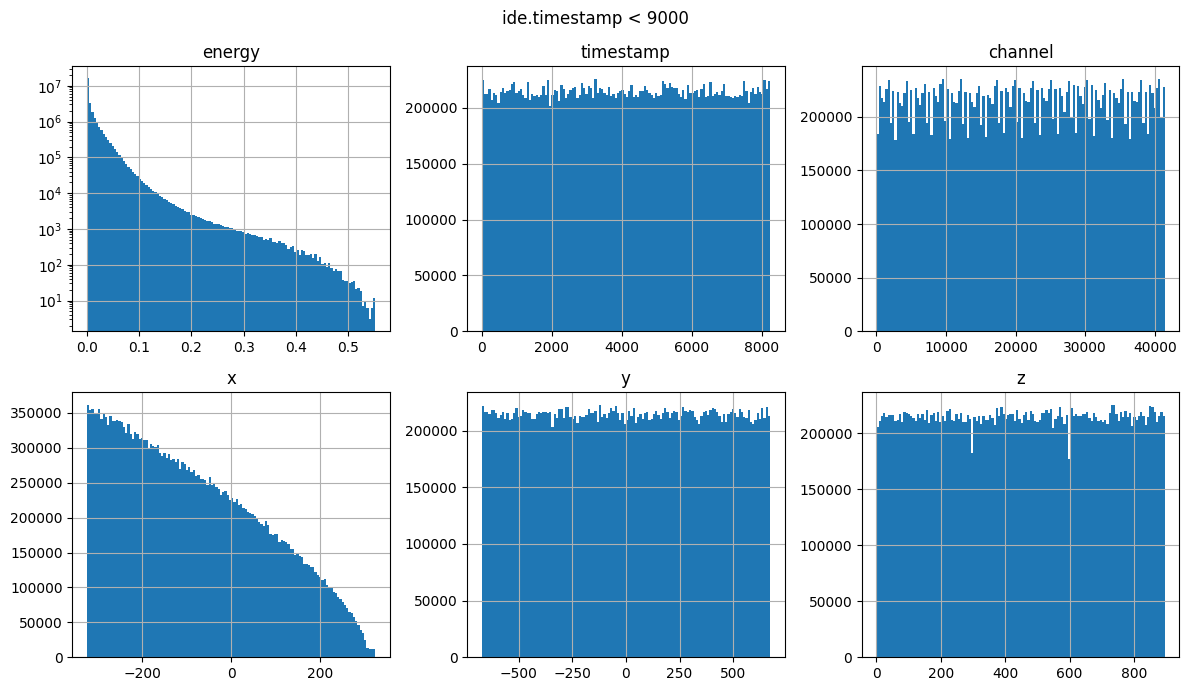

In [121]:
fig,axes = plt.subplots(2,3, figsize=(12,7))

q='timestamp < 9000 & event<100'
b=128

ax=axes[0][0]
ws.ides.query(q).energy.hist(ax=ax, bins=b)
ax.set_title('energy')
ax.set_yscale('log')

ax=axes[0][1]
ws.ides.query(q).timestamp.hist(ax=ax, bins=b)
ax.set_title('timestamp')

ax=axes[0][2]
ws.ides.query(q).channel.hist(ax=ax, bins=b)
ax.set_title('channel')

ax=axes[1][0]
ws.ides.query(q).x.hist(ax=ax, bins=b)
ax.set_title('x')

ax=axes[1][1]
ws.ides.query(q).y.hist(ax=ax, bins=b)
ax.set_title('y')

ax=axes[1][2]
ws.ides.query(q).z.hist(ax=ax, bins=b)
ax.set_title('z')

fig.suptitle('ide.timestamp < 9000')
fig.tight_layout()


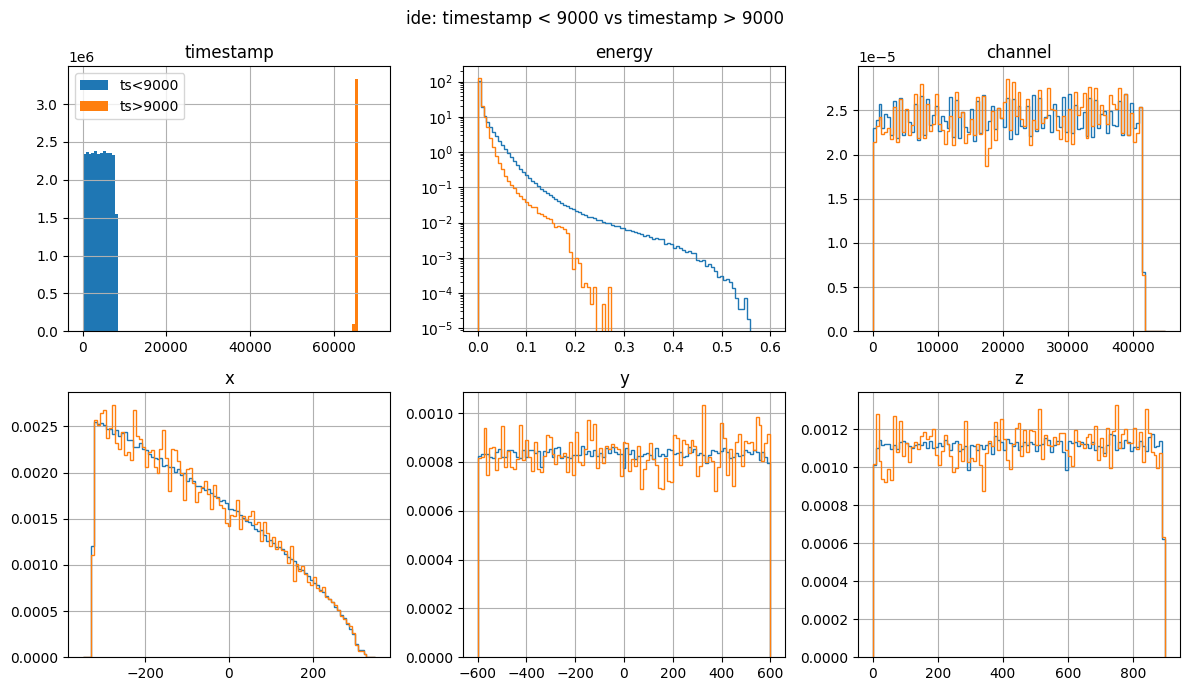

In [131]:
fig,axes = plt.subplots(2,3, figsize=(12,7))

q1='timestamp < 9000 & event<100'
q2='timestamp > 9000 & event<100'


bins=np.linspace(0, 70000, 100)

ax=axes[0][0]
ws.ides.query(q1).timestamp.hist(ax=ax, bins=bins, label='ts<9000')
ws.ides.query(q2).timestamp.hist(ax=ax, bins=bins, label='ts>9000')
ax.legend()

ax.set_title('timestamp')



bins=np.linspace(0, 0.6, 100)

ax=axes[0][1]
ws.ides.query(q1).energy.hist(ax=ax, bins=bins, histtype='step', density=True)
ws.ides.query(q2).energy.hist(ax=ax, bins=bins, histtype='step', density=True)
ax.set_title('energy')
ax.set_yscale('log')


bins=np.linspace(0, 45000, 100)

ax=axes[0][2]
ws.ides.query(q1).channel.hist(ax=ax, bins=bins, histtype='step', density=True)
ws.ides.query(q2).channel.hist(ax=ax, bins=bins, histtype='step', density=True)
ax.set_title('channel')


bins=np.linspace(-350, 350, 100)

ax=axes[1][0]
ws.ides.query(q1).x.hist(ax=ax, bins=bins, histtype='step', density=True)
ws.ides.query(q2).x.hist(ax=ax, bins=bins, histtype='step', density=True)
ax.set_title('x')


bins=np.linspace(-600, 600, 100)

ax=axes[1][1]
ws.ides.query(q1).y.hist(ax=ax, bins=bins, histtype='step', density=True)
ws.ides.query(q2).y.hist(ax=ax, bins=bins, histtype='step', density=True)
ax.set_title('y')


bins=np.linspace(0, 900, 100)

ax=axes[1][2]
ws.ides.query(q1).z.hist(ax=ax, bins=bins, histtype='step', density=True)
ws.ides.query(q2).z.hist(ax=ax, bins=bins, histtype='step', density=True)
ax.set_title('z')

fig.suptitle('ide: timestamp < 9000 vs timestamp > 9000')
fig.tight_layout()


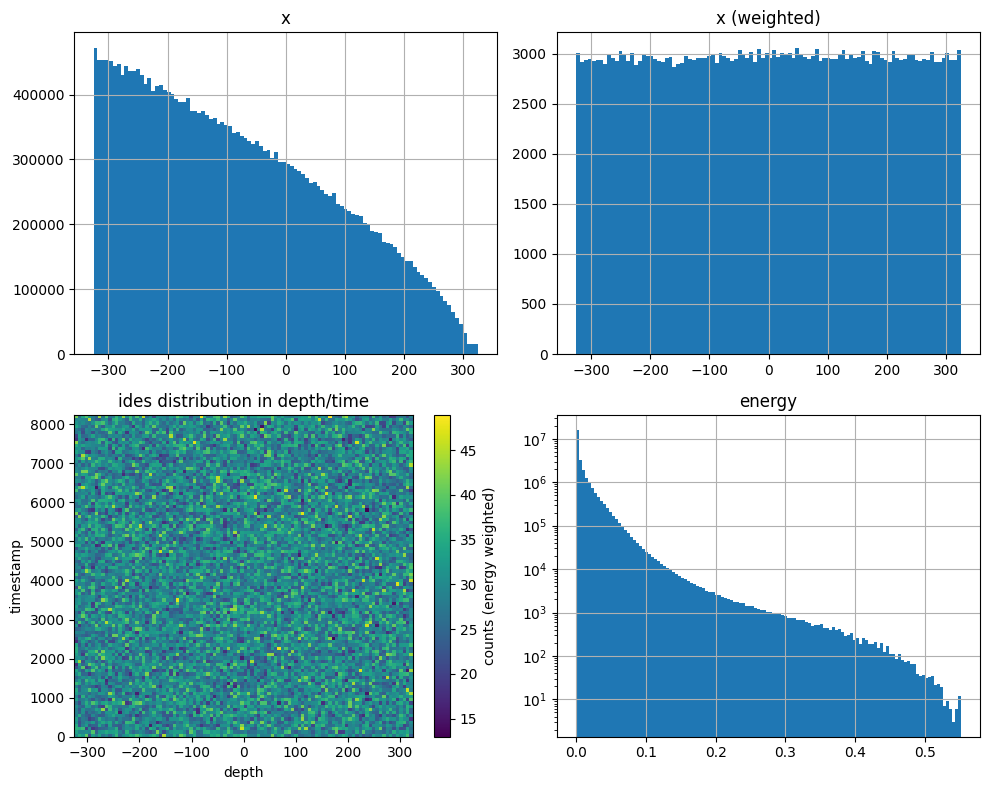

In [11]:
import matplotlib as mpl
fig, axes = plt.subplots(2,2, figsize=(10,8))
norm=mpl.colors.LogNorm()

ides_clean = ws.ides.query('timestamp < 10000')


ax=axes[0][0]
ides_clean.x.hist(bins=100, ax=ax)
ax.set_title('x')

ax=axes[0][1]
ides_clean.x.hist(bins=100, weights=ides_clean.energy, ax=ax)
ax.set_title('x (weighted)')

ax = axes[1][0]
h2d = ax.hist2d(ides_clean.x, ides_clean.timestamp, weights=ides_clean.energy, bins=(100, 100))
ax.set_ylabel('timestamp')
ax.set_xlabel('depth')
cbar = fig.colorbar(h2d[3], ax=ax)
cbar.set_label('counts (energy weighted)')
ax.set_title('ides distribution in depth/time')

ax=axes[1][1]
ides_clean.energy.hist(ax=ax, bins=b)
ax.set_title('energy')
ax.set_yscale('log')

fig.tight_layout()

<Axes: >

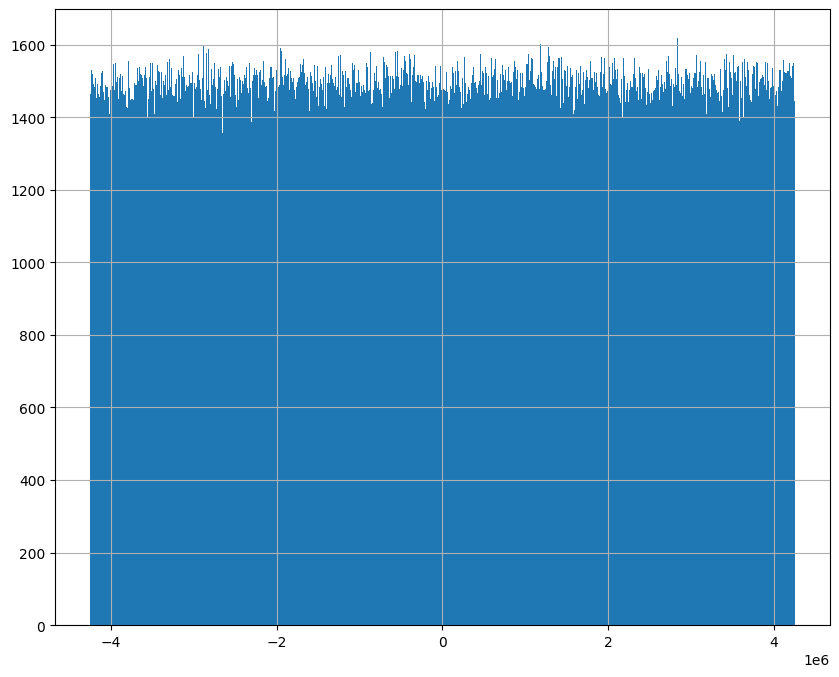

In [12]:
fig, axes = plt.subplots(1,1, squeeze=False, figsize=(10,8))

ax = axes[0,0]
ws.mcparticles.t.hist(ax=ax, bins=1000)

## Start of the readout window - missing activity
### Trigger primitives

In [ ]:
pd.options.plotting.backend = 'plotly'
import plotly.express as px
# ws.tps.query('event == 1 & TP_peakADC > 50').plot.scatter(x='TP_channel', y='TP_peakT', size='TP_peakADC', color_continuous_scale=px.colors.sequential.Viridis, height=500, width=600)

pd.options.plotting.backend = 'matplotlib'
with pandas_backend('plotly') as x:
    f = ws.tps.query('event == 1 & adc_peak > 50').plot.scatter(x='channel', y='sample_start', size='adc_peak', color="bt_is_signal", color_continuous_scale=px.colors.sequential.Viridis, height=800, width=900)
    f.show()


In [ ]:
pd.options.plotting.backend = 'plotly'
import plotly.express as px
# ws.tps.query('event == 1 & TP_peakADC > 50').plot.scatter(x='TP_channel', y='TP_peakT', size='TP_peakADC', color_continuous_scale=px.colors.sequential.Viridis, height=500, width=600)

pd.options.plotting.backend = 'matplotlib'
with pandas_backend('plotly') as x:
    f = ws.tps.query('sample_start < 200 & readout_plane_id == 2 & adc_peak > 50').plot.scatter(x='channel', y='sample_start', size='adc_peak', color="bt_is_signal", color_continuous_scale=px.colors.sequential.Viridis, height=800, width=900)
    f.show()


In [75]:
ar39_wf = ws.get_waveforms(1)

## Check for signs of activity in waveforms

In [15]:
from tpvalidator.mcprod.geometry import FDVDGeometry_1x6x8


chans = [c for c in wf.columns if c not in ('event', 'run', 'subrun', 'sample_id')]
loc_chans = [c %  FDVDGeometry_1x6x8.crp_tot_num_chans_sim for c in chans]

crp_view_bins = [
    0,
    FDVDGeometry_1x6x8.crp_view_0_num_chans_sim,
    FDVDGeometry_1x6x8.crp_view_0_num_chans_sim+FDVDGeometry_1x6x8.crp_view_1_num_chans_sim,            
    FDVDGeometry_1x6x8.crp_view_0_num_chans_sim+FDVDGeometry_1x6x8.crp_view_1_num_chans_sim+FDVDGeometry_1x6x8.crp_view_2_num_chans_sim,
]

chan_view = [v-1 for v in np.digitize(loc_chans, crp_view_bins)]


chan_view_map = {c:int(v) for c,v in zip(chans, chan_view)}


<Axes: >

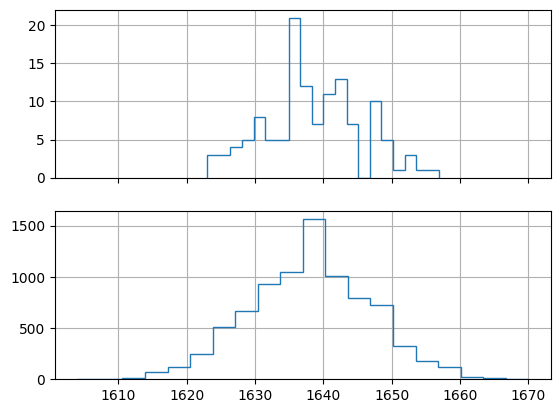

In [16]:
fig, axes = plt.subplots(2,1, sharex=True)
wf.query('sample_id < 125')[41471].hist(bins=20, histtype='step', ax=axes[0])
wf.query('sample_id > 125')[41471].hist(bins=20, histtype='step', ax=axes[1])

In [ ]:


def hist_and_sum(df, chans, bins):
    histograms = {}
    for c in chans:

        hist, _ = np.histogram(df[c], bins=bins)
        histograms[c] = hist

    total_hist = np.sum(list(histograms.values()), axis=0)
    return histograms, total_hist



/var/folders/dw/sj94s2457kl2gkb829ty4_cc0000gn/T/ipykernel_36252/3603241749.py:57: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/dw/sj94s2457kl2gkb829ty4_cc0000gn/T/ipykernel_36252/3603241749.py:57: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



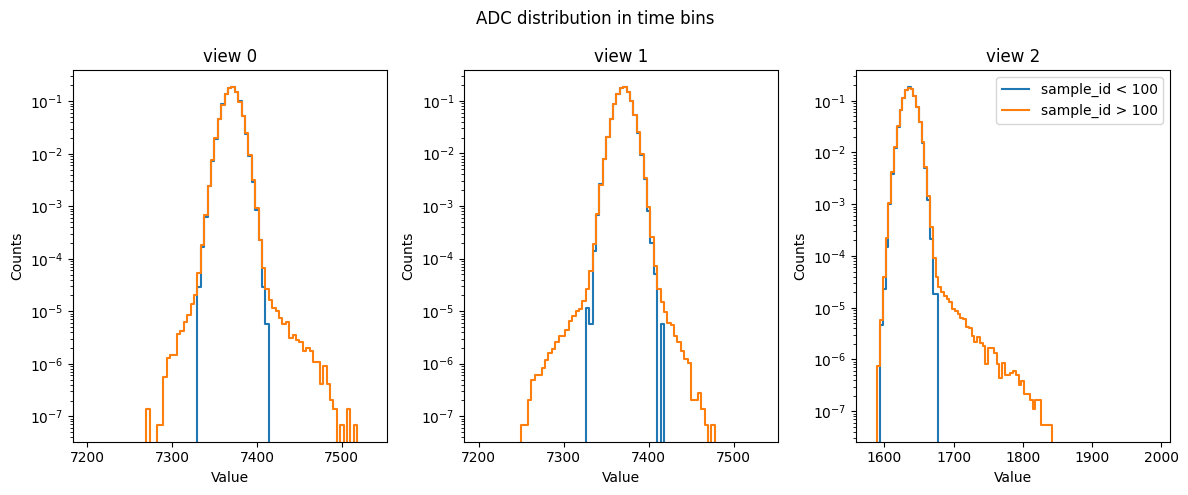

In [76]:
from tpvalidator.mcprod.geometry import FDVDGeometry_1x6x8


wf_chans = [c for c in ar39_wf.columns if c not in ('event', 'run', 'subrun', 'sample_id')]
loc_chans = [c %  FDVDGeometry_1x6x8.crp_tot_num_chans_sim for c in wf_chans]

tpc_view_bins = [
    0,
    FDVDGeometry_1x6x8.tpc_view_0_num_chans_sim,
    FDVDGeometry_1x6x8.tpc_view_0_num_chans_sim+FDVDGeometry_1x6x8.tpc_view_1_num_chans_sim,            
    FDVDGeometry_1x6x8.tpc_view_0_num_chans_sim+FDVDGeometry_1x6x8.tpc_view_1_num_chans_sim+FDVDGeometry_1x6x8.tpc_view_2_num_chans_sim,
]

chan_view = [v-1 for v in np.digitize(loc_chans, tpc_view_bins)]


chan_view_map = {c:int(v) for c,v in zip(wf_chans, chan_view)}
bins_v2 = np.linspace(1580, 1860, 71)
bins_v2 = np.arange(1580, 2000,4)
bins_v01 = np.linspace(7200, 7540, 86)

ro_view = 1
chans = [c for c in wf_chans if chan_view_map[c] == ro_view]
bins = bins_v01 if ro_view in [0,1] else bins_v2

boundary = 100


queries = [
    f'sample_id < {boundary}',
    f'sample_id > {boundary}',
    # f'sample_id > 5000'
]


fig, axes = plt.subplots(1,3, figsize=(12, 5))


for v in range(3):
    ax = axes[v]
    chans = [c for c in wf_chans if chan_view_map[c] == v]
    bins = bins_v01 if v in [0,1] else bins_v2

    for q in queries:
        hists, total_hist = hist_and_sum(ar39_wf.query(q), chans, bins)
        # print(total_hist)
        norm_hist = total_hist / np.sum(total_hist)
        # print(norm_hist)

        ax.step(bins[:-1], norm_hist, where='mid', label=q)

    ax.set_xlabel("Value")
    ax.set_ylabel("Counts")
    ax.set_yscale("log")
    ax.set_title(f"view {v}")

    plt.legend()
fig.suptitle(f"ADC distribution in time bins")
fig.tight_layout()



# Radiologicals

In [19]:
with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.INFO):
    rad_ws = workspace.TriggerPrimitivesWorkspace("../../data/vd/bkg/100events/trigtree_tpg_vd_radiols.root")

print(rad_ws.info)

INFO:TriggerPrimitivesWorkspace:Opening Trigger Primitives file
INFO:TriggerPrimitivesWorkspace:Adding processing info
INFO:TriggerPrimitivesWorkspace:Adding Event Summary data
INFO:TriggerPrimitivesWorkspace:triggerAna/event_summary found with 100 rows
INFO:TriggerPrimitivesWorkspace:Adding MCTruth data
INFO:TriggerPrimitivesWorkspace:triggerAna/mctruths found with 7429070 rows
INFO:TriggerPrimitivesWorkspace:Adding MCNeutrino data
INFO:TriggerPrimitivesWorkspace:triggerAna/mcneutrinos found with 0 rows
INFO:TriggerPrimitivesWorkspace:Adding MCParticles data
INFO:TriggerPrimitivesWorkspace:triggerAna/mcparticles found with 7429101 rows
INFO:TriggerPrimitivesWorkspace:Adding IDEs data
INFO:TriggerPrimitivesWorkspace:triggerAna/simides found with 46831493 rows
INFO:TriggerPrimitivesWorkspace:tpmakerTPCSimpleThreshold__TriggerPrimitiveMaker found with 1552294 rows


None

{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 38,
            'threshold_tpg_plane1': 38,
            'threshold_tpg_plane2': 44,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

In [20]:
rad_ws.add_rawdigits('../../data/vd/bkg/100events/trigger_digits_waves_detsim_vd_radiols.root')

In [21]:
rad_wf = rad_ws.get_waveforms(1)

[1]

1

/Users/ale/Development/dune/trigger-studies/tpvalidator/src/tpvalidator/mcprod/workspace.py:510: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



/var/folders/dw/sj94s2457kl2gkb829ty4_cc0000gn/T/ipykernel_36252/37155331.py:57: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/dw/sj94s2457kl2gkb829ty4_cc0000gn/T/ipykernel_36252/37155331.py:57: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



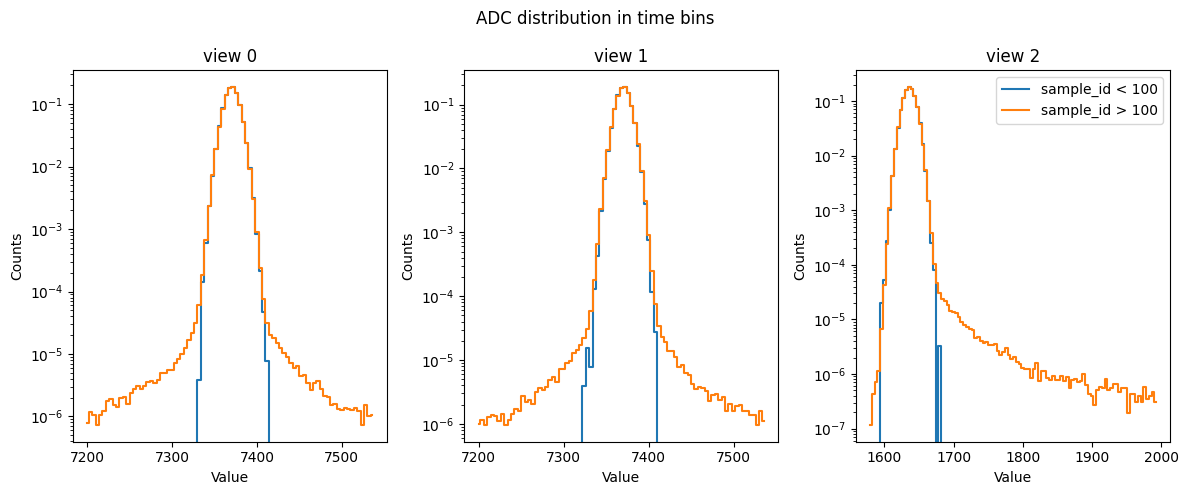

In [77]:
from tpvalidator.mcprod.geometry import FDVDGeometry_1x6x8


wf_chans = [c for c in rad_wf.columns if c not in ('event', 'run', 'subrun', 'sample_id')]
loc_chans = [c %  FDVDGeometry_1x6x8.crp_tot_num_chans_sim for c in wf_chans]

tpc_view_bins = [
    0,
    FDVDGeometry_1x6x8.tpc_view_0_num_chans_sim,
    FDVDGeometry_1x6x8.tpc_view_0_num_chans_sim+FDVDGeometry_1x6x8.tpc_view_1_num_chans_sim,            
    FDVDGeometry_1x6x8.tpc_view_0_num_chans_sim+FDVDGeometry_1x6x8.tpc_view_1_num_chans_sim+FDVDGeometry_1x6x8.tpc_view_2_num_chans_sim,
]

chan_view = [v-1 for v in np.digitize(loc_chans, tpc_view_bins)]


chan_view_map = {c:int(v) for c,v in zip(wf_chans, chan_view)}
bins_v2 = np.linspace(1580, 1860, 71)
bins_v2 = np.arange(1580, 2000,4)
bins_v01 = np.linspace(7200, 7540, 86)

ro_view = 1
chans = [c for c in wf_chans if chan_view_map[c] == ro_view]
bins = bins_v01 if ro_view in [0,1] else bins_v2

boundary = 100


queries = [
    f'sample_id < {boundary}',
    f'sample_id > {boundary}',
    # f'sample_id > 5000'
]


fig, axes = plt.subplots(1,3, figsize=(12, 5))


for v in range(3):
    ax = axes[v]
    chans = [c for c in wf_chans if chan_view_map[c] == v]
    bins = bins_v01 if v in [0,1] else bins_v2

    for q in queries:
        hists, total_hist = hist_and_sum(rad_wf.query(q), chans, bins)
        # print(total_hist)
        norm_hist = total_hist / np.sum(total_hist)
        # print(norm_hist)

        ax.step(bins[:-1], norm_hist, where='mid', label=q)

    ax.set_xlabel("Value")
    ax.set_ylabel("Counts")
    ax.set_yscale("log")
    ax.set_title(f"view {v}")

    plt.legend()
fig.suptitle(f"ADC distribution in time bins")
fig.tight_layout()

